# ECCO HEAT & SALT BUDGET

In [1]:
from dask_gateway import Gateway

g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1c6297b2621c42aa82050b0bec89c8aa/status,


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

## Open ECCO Dataset from the Cloud

In [4]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [5]:
dt_values = (np.diff(ds.time_snp) / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'],
                  coords={'time': (['time'], ds.time.values[1:-1])})
ds.coords['dt'] = dt
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll#.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])
# a trick to make things work a bit faster
coordsr = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50, roll_coords=True)#(i=100, i_g=100)
dsr = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50, roll_coords=True)#(i=100, i_g=100)
dsr

,Array,Chunk
Bytes,5.21 GiB,1.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 90, 90)"
Count,31 Graph Layers,3456 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.21 GiB,1.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 90, 90)"
Count,31 Graph Layers,3456 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
#view current coord structure of i
coordsr.i.values
#locate 0, that's where -180 is
coordsr.i.values[50]
#create lon object to replace current i indexing
lon = np.arange(-180, 180)
#roll lon appropriately so new indexing values matches actual grid
lon_rolled = np.roll(lon, 50)
#insert new lon indices for both i & i_g
dsr['i'] = lon_rolled
dsr['i_g'] = lon_rolled
coordsr['i'] = lon_rolled
coordsr['i_g'] = lon_rolled

## New northern boundary | Visualize the ACC region you're going to ignore

In [7]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 90 #-56.73891

#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))
lat_range_u = dict(j_g=slice(lower_lat, upper_lat))
lon_range_u = dict(i_g=slice(left_lon, right_lon))

t = 30
level = 0

coords = coordsr.isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
ds = dsr.isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)

In [8]:
temp = ds.THETA[0,0].drop('i')
mask = coords.drop('i').hFacC[0] > 0

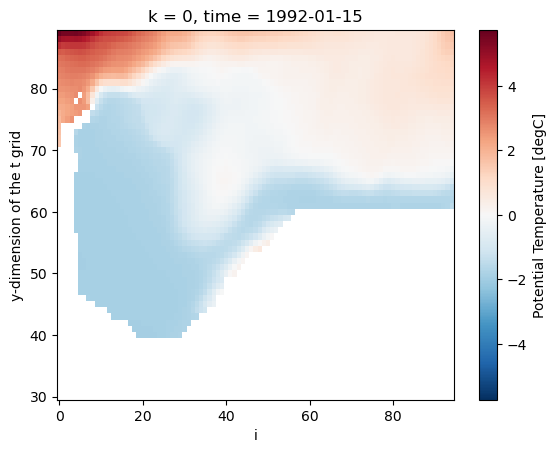

In [9]:
temp.where(mask).plot();

In [10]:
#mask out the acc in the corner
mask_acc = xr.ones_like(temp)

mask_acc[50:None, None:12] = 0
mask_acc[47:50, None:9] = 0
mask_acc[45:47, None:8] = 0
mask_acc[41:45, None:2] = 0

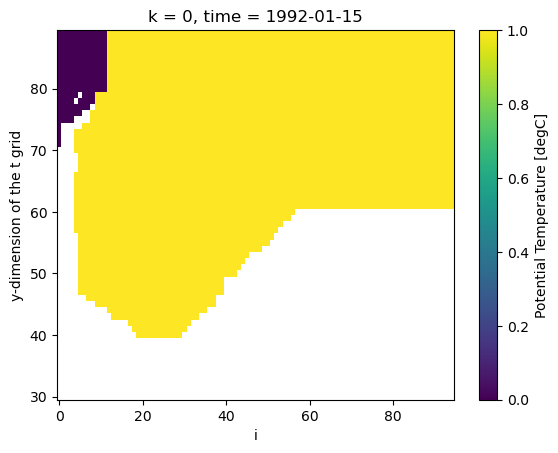

In [11]:
mask_acc.where(mask).plot();

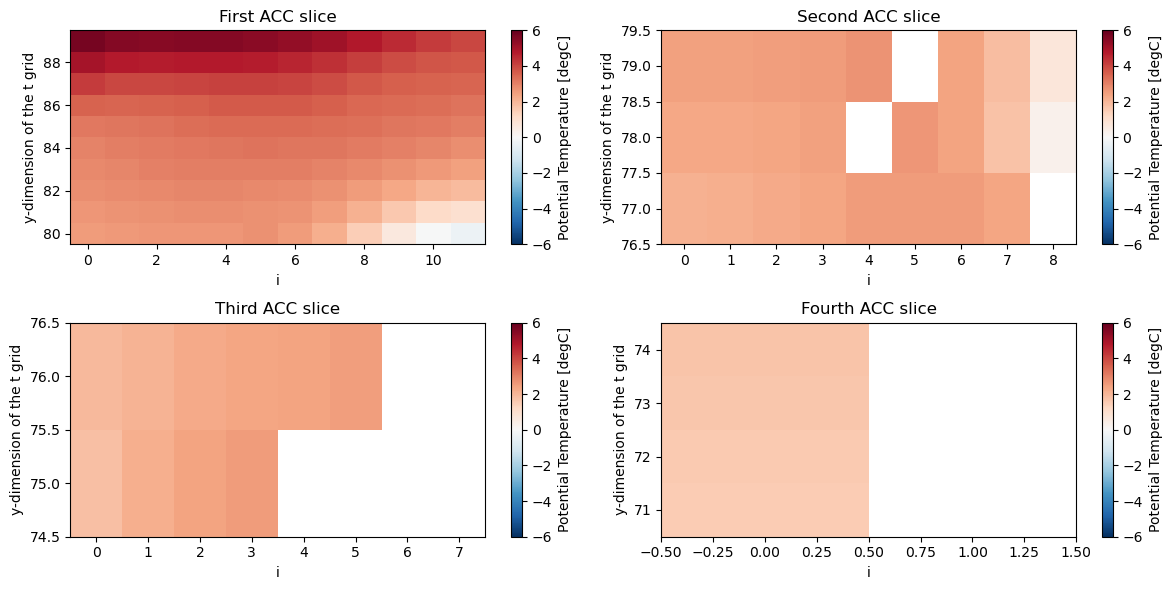

In [12]:
#visualize the 3 masks
fig, ax = plt.subplots(2,2, figsize=(12,6))

temp.where(mask)[50:None, None:12].plot(ax=ax[0,0], cmap='RdBu_r', vmin=-6, vmax=6)
ax[0,0].set_title('First ACC slice')
temp.where(mask)[47:50, None:9].plot(ax=ax[0,1], cmap='RdBu_r', vmin=-6, vmax=6)
ax[0,1].set_title('Second ACC slice')
temp.where(mask)[45:47, None:8].plot(ax=ax[1,0], cmap='RdBu_r', vmin=-6, vmax=6)
ax[1,0].set_title('Third ACC slice')
temp.where(mask)[41:45, None:2].plot(ax=ax[1,1], cmap='RdBu_r', vmin=-6, vmax=6)
ax[1,1].set_title('Fourth ACC slice')

plt.tight_layout();

In [13]:
# Given upper right / lower left cell coordinates, construct the tx_trans and ty_trans sections that bound it

def box_budget(left_i, right_i, lower_j, upper_j,):
    """Function to compute box budget given any set of boundaries"""

    UTRANS = ds.UVELMASS * coords.dyG * coords.drF 
    VTRANS = ds.VVELMASS * coords.dxG * coords.drF

    ty_upper = VTRANS.isel(i=slice(left_i, right_i), j_g=upper_j)
    ty_lower = VTRANS.isel(i=slice(left_i, right_i), j_g=lower_j)
    tx_right = UTRANS.isel(i_g=right_i, j=slice(lower_j, upper_j))
    tx_left = UTRANS.isel(i_g=left_i, j=slice(lower_j, upper_j))

    return (-ty_upper.mean('time').sum().values + ty_lower.mean('time').sum().values 
            - tx_right.mean('time').sum().values + tx_left.mean('time').sum().values)

In [14]:
UTRANS = ds.UVELMASS * coords.dyG * coords.drF * coords.hFacW
VTRANS = ds.VVELMASS * coords.dxG * coords.drF * coords.hFacS

In [15]:
UTRANS.coords

Coordinates:
  * i_g      (i_g) int64 153 154 155 156 157 158 ... -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [16]:
VTRANS.coords

Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j_g      (j_g) int64 30 31 32 33 34 35 36 37 38 ... 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [17]:
UTRANS.shape

(288, 50, 60, 95)

In [18]:
VTRANS.shape

(288, 50, 60, 95)

if reisidual is still too high
- Try adding hfac back in without changing anything else
- Try the raw cell of ± 1 without hfacc
- Try raw cell of ± 1 with hfacc

In [19]:
box1 = box_budget(12, 94, 50, 59)
box2 = box_budget(9, 94, 47, 50)
box3 = box_budget(8, 94, 45, 47)
box4 = box_budget(2, 94, 41, 45)
box5 = box_budget(0, 94, 0, 41)

residual = box1 + box2 + box3 + box4
(residual / 1e6)

-0.095004375

# Heat budget

In [20]:
#load in autoreload so you don't have to restart kernel everytime you want to run bb function
%load_ext autoreload

#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [21]:
import bb

In [22]:
#testing imported bb module

#area-weighting velocities
UVEL = ds.UVELMASS * coords.dyG * coords.drF 
VVEL = ds.VVELMASS * coords.dxG * coords.drF

#testing generalized function for transport

box1 = bb.box_budget(UVEL, VVEL, 12, 94, 50, 59)
box2 = bb.box_budget(UVEL, VVEL, 9, 94, 47, 50)
box3 = bb.box_budget(UVEL, VVEL, 8, 94, 45, 47)
box4 = bb.box_budget(UVEL, VVEL, 2, 94, 41, 45)
box5 = bb.box_budget(UVEL, VVEL, 0, 94, 0, 41)

residual_vel = box1 + box2 + box3 + box4 + box5
(residual_vel.mean('time')/1e6).values

array(-0.07563032, dtype=float32)

In [23]:
print('box1: ', (box1.mean('time').values/1e6), 
      '\n box2: ', (box2.mean('time').values/1e6),
      '\n box2: ', (box3.mean('time').values/1e6),
      '\n box2: ', (box4.mean('time').values/1e6))

box1:  -0.06324570703125 
 box2:  -0.0140249462890625 
 box2:  -0.00668469189453125 
 box2:  -0.0110503994140625


### Advection term

In [24]:
box1 = bb.box_budget(ds.ADVx_TH, ds.ADVy_TH, 12, 94, 50, 59)
box2 = bb.box_budget(ds.ADVx_TH, ds.ADVy_TH, 9, 94, 47, 50)
box3 = bb.box_budget(ds.ADVx_TH, ds.ADVy_TH, 8, 94, 45, 47)
box4 = bb.box_budget(ds.ADVx_TH, ds.ADVy_TH, 2, 94, 41, 45)
box5 = bb.box_budget(ds.ADVx_TH, ds.ADVy_TH, 0, 94, 0, 41)

residual_adv = box1 + box2 + box3 + box4 + box5

### Diffusion term

In [25]:
box1 = bb.box_budget(ds.DFxE_TH, ds.DFyE_TH, 12, 94, 50, 59)
box2 = bb.box_budget(ds.DFxE_TH, ds.DFyE_TH, 9, 94, 47, 50)
box3 = bb.box_budget(ds.DFxE_TH, ds.DFyE_TH, 8, 94, 45, 47)
box4 = bb.box_budget(ds.DFxE_TH, ds.DFyE_TH, 2, 94, 41, 45)
box5 = bb.box_budget(ds.DFxE_TH, ds.DFyE_TH, 0, 94, 0, 41)

residual_diff = box1 + box2 + box3 + box4 + box5

### Surface term

In [26]:
#surface tflux box
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3

tflux = (ds.TFLUX * coords.rA * coords.hFacC[0]) / (heat_capacity_cp * runit2mass)

box1 = tflux.isel(j=slice(50, 59), i=slice(12, None)).sum(dim=['i','j'])
box2 = tflux.isel(j=slice(47, 50), i=slice(9, None)).sum(dim=['i','j'])
box3 = tflux.isel(j=slice(45, 47), i=slice(8, None)).sum(dim=['i','j'])
box4 = tflux.isel(j=slice(41, 45), i=slice(2, None)).sum(dim=['i','j'])
box5 = tflux.isel(j=slice(None, 41)).sum(dim=['i','j'])

residual_surf = box1 + box2 + box3 + box4 + box5

### Total tendency term (LHS)

In [27]:
#calculating total tendency term for heat
delta_theta = ds.THETA_snp.diff('time_snp')

#forcing theta_scaled to have same timestamp as ds.dt by creating new data array called "theta_scaled"
delta_theta = xr.DataArray(delta_theta.data, dims=['time','k','j','i'], 
                            coords={'time': coords.dt[1:287].time.data,
                                    'k':coords.k.data,
                                    'j':coords.j.data,
                                    'i':coords.i.data})
delta_theta

,Array,Chunk
Bytes,310.94 MiB,785.16 kiB
Shape,"(286, 50, 60, 95)","(1, 50, 60, 67)"
Count,35 Graph Layers,572 Chunks
Type,float32,numpy.ndarray


In [28]:
theta_tend = (delta_theta / coords.dt[1:287])
volume = (coords.drF * coords.rA * coords.hFacC)
totttend = theta_tend * volume

In [29]:
#tottend box
box1 = totttend.isel(j=slice(50, 59), i=slice(12, None)).sum(dim=['i','j', 'k'])
box2 = totttend.isel(j=slice(47, 50), i=slice(9, None)).sum(dim=['i','j', 'k'])
box3 = totttend.isel(j=slice(45, 47), i=slice(8, None)).sum(dim=['i','j', 'k'])
box4 = totttend.isel(j=slice(41, 45), i=slice(2, None)).sum(dim=['i','j', 'k'])
box5 = totttend.isel(j=slice(None, 41)).sum(dim=['i','j', 'k'])

residual_tot = box1 + box2 + box3 + box4 + box5

### LHS = RHS

In [30]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1c6297b2621c42aa82050b0bec89c8aa/status,


In [31]:
residual_adv.load();
residual_diff.load();
residual_surf.load();
residual_tot.load();

In [32]:
rhs = residual_adv[1:-1] + residual_diff[1:-1] + residual_surf[1:-1]
lhs = residual_tot

In [33]:
((rhs-lhs).mean('time')/1e6).values

array(-0.332911)

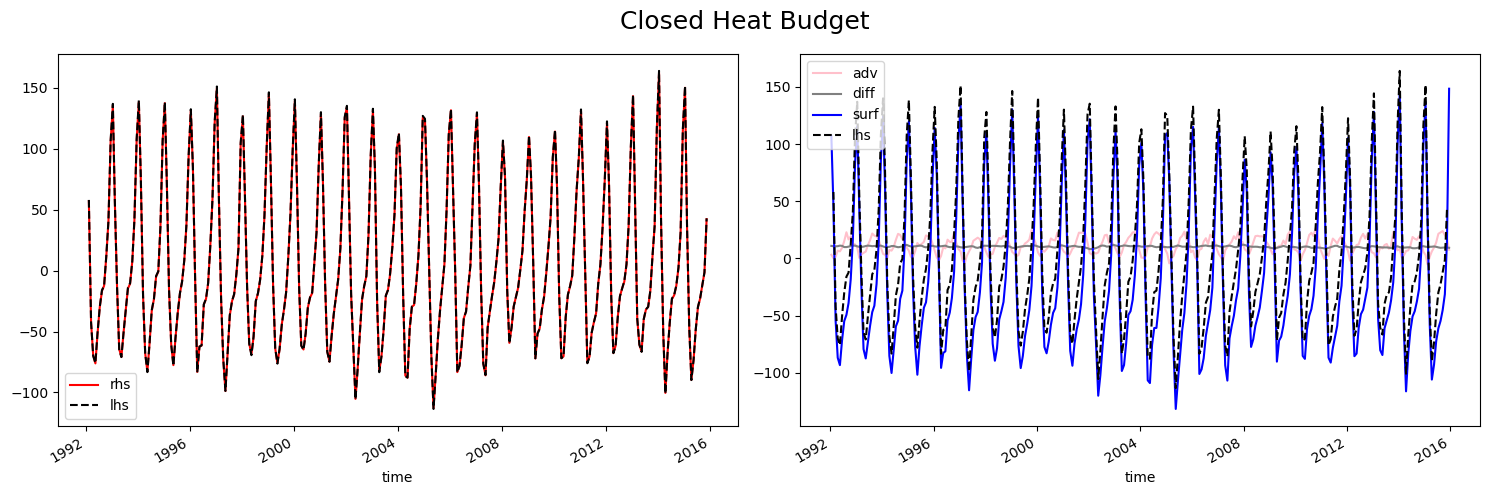

In [34]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))

(rhs/1e6).plot(color='r', label='rhs', ax=ax0)
(lhs/1e6).plot(color='k', linestyle='--', label='lhs', ax=ax0)
ax0.legend()

(residual_adv/1e6).plot(color='pink', label='adv', ax=ax1)
(residual_diff/1e6).plot(color='grey', label='diff', ax=ax1)
(residual_surf/1e6).plot(color='blue', label='surf', ax=ax1)
(lhs/1e6).plot(color='k', linestyle='--', label='lhs', ax=ax1)
ax1.legend()

plt.suptitle('Closed Heat Budget', fontsize=18)
plt.tight_layout();

# SALT BUDGET

### Advection term

In [35]:
box1 = bb.box_budget(ds.ADVx_SLT, ds.ADVy_SLT, 12, 94, 50, 59)
box2 = bb.box_budget(ds.ADVx_SLT, ds.ADVy_SLT, 9, 94, 47, 50)
box3 = bb.box_budget(ds.ADVx_SLT, ds.ADVy_SLT, 8, 94, 45, 47)
box4 = bb.box_budget(ds.ADVx_SLT, ds.ADVy_SLT, 2, 94, 41, 45)
box5 = bb.box_budget(ds.ADVx_SLT, ds.ADVy_SLT, 0, 94, 0, 41)

residual_adv = box1 + box2 + box3 + box4 + box5

### Diffusion term

In [36]:
box1 = bb.box_budget(ds.DFxE_SLT, ds.DFyE_SLT, 12, 94, 50, 59)
box2 = bb.box_budget(ds.DFxE_SLT, ds.DFyE_SLT, 9, 94, 47, 50)
box3 = bb.box_budget(ds.DFxE_SLT, ds.DFyE_SLT, 8, 94, 45, 47)
box4 = bb.box_budget(ds.DFxE_SLT, ds.DFyE_SLT, 2, 94, 41, 45)
box5 = bb.box_budget(ds.DFxE_SLT, ds.DFyE_SLT, 0, 94, 0, 41)

residual_diff = box1 + box2 + box3 + box4 + box5

### Surface term

In [37]:
#surface slfux box
runit2mass = 1.035e3 #kg/m^3

sflux = (ds.SFLUX * coords.rA * coords.hFacC[0]) / runit2mass

box1 = sflux.isel(j=slice(50, 59), i=slice(12, None)).sum(dim=['i','j'])
box2 = sflux.isel(j=slice(47, 50), i=slice(9, None)).sum(dim=['i','j'])
box3 = sflux.isel(j=slice(45, 47), i=slice(8, None)).sum(dim=['i','j'])
box4 = sflux.isel(j=slice(41, 45), i=slice(2, None)).sum(dim=['i','j'])
box5 = sflux.isel(j=slice(None, 41)).sum(dim=['i','j'])

residual_surf = box1 + box2 + box3 + box4 + box5

## Salt Plume

In [52]:
runit2mass = 1.035e3 #kg/m^3
salt_plume = ((ds.oceSPtnd * coords.rA * coords.hFacC)/runit2mass)#.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})

box1 = salt_plume.isel(j=slice(50, 59), i=slice(12, None)).sum(dim=['i','j', 'k'])
box2 = salt_plume.isel(j=slice(47, 50), i=slice(9, None)).sum(dim=['i','j', 'k'])
box3 = salt_plume.isel(j=slice(45, 47), i=slice(8, None)).sum(dim=['i','j', 'k'])
box4 = salt_plume.isel(j=slice(41, 45), i=slice(2, None)).sum(dim=['i','j', 'k'])
box5 = salt_plume.isel(j=slice(None, 41)).sum(dim=['i','j', 'k'])

residual_splume = box1 + box2 + box3 + box4 + box5

### Total tendency term (LHS)

In [38]:
#calculating total tendency term for salt
delta_salt = ds.SALT_snp.diff('time_snp')
#forcing salt_scaled to have same timestamp as ds.dt by creating new data array called "salt_scaled"
delta_salt = xr.DataArray(delta_salt.data, dims=['time','k','j','i'], 
                            coords={'time': coords.dt[1:287].time.data})
delta_salt

,Array,Chunk
Bytes,310.94 MiB,785.16 kiB
Shape,"(286, 50, 60, 95)","(1, 50, 60, 67)"
Count,35 Graph Layers,572 Chunks
Type,float32,numpy.ndarray


In [39]:
salt_tend = (delta_salt / coords.dt[1:287])
#units: g/kg*s (psu/s)
volume = (coords.drF * coords.rA * coords.hFacC)
totstend = salt_tend * volume

In [40]:
#tottend box
box1 = totstend.isel(j=slice(50, 59), i=slice(12, None)).sum(dim=['i','j', 'k'])
box2 = totstend.isel(j=slice(47, 50), i=slice(9, None)).sum(dim=['i','j', 'k'])
box3 = totstend.isel(j=slice(45, 47), i=slice(8, None)).sum(dim=['i','j', 'k'])
box4 = totstend.isel(j=slice(41, 45), i=slice(2, None)).sum(dim=['i','j', 'k'])
box5 = totstend.isel(j=slice(None, 41)).sum(dim=['i','j', 'k'])

residual_tot = box1 + box2 + box3 + box4 + box5

### LHS = RHS

In [41]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1c6297b2621c42aa82050b0bec89c8aa/status,


In [53]:
residual_adv.load();
residual_diff.load();
residual_surf.load();
residual_splume.load();
residual_tot.load();

In [60]:
residual_adv.mean('time') / 1e6

<xarray.DataArray ()>
array(0.31514522)

In [61]:
residual_diff.mean('time') / 1e6

<xarray.DataArray ()>
array(0.47826544)

In [62]:
residual_surf.mean('time') / 1e6

<xarray.DataArray ()>
array(-2.8488035)
Coordinates:
    k        int64 0

In [63]:
residual_splume.mean('time') / 1e6

<xarray.DataArray ()>
array(2.8306865)

In [64]:
residual_tot.mean('time') / 1e6

<xarray.DataArray ()>
array(0.90254406)

In [79]:
rhs = residual_adv[1:-1] + residual_diff[1:-1] + residual_surf[1:-1] + residual_splume[1:-1]
lhs = residual_tot

In [80]:
((rhs-lhs).mean('time')/1e6).values

array(-0.1383762)

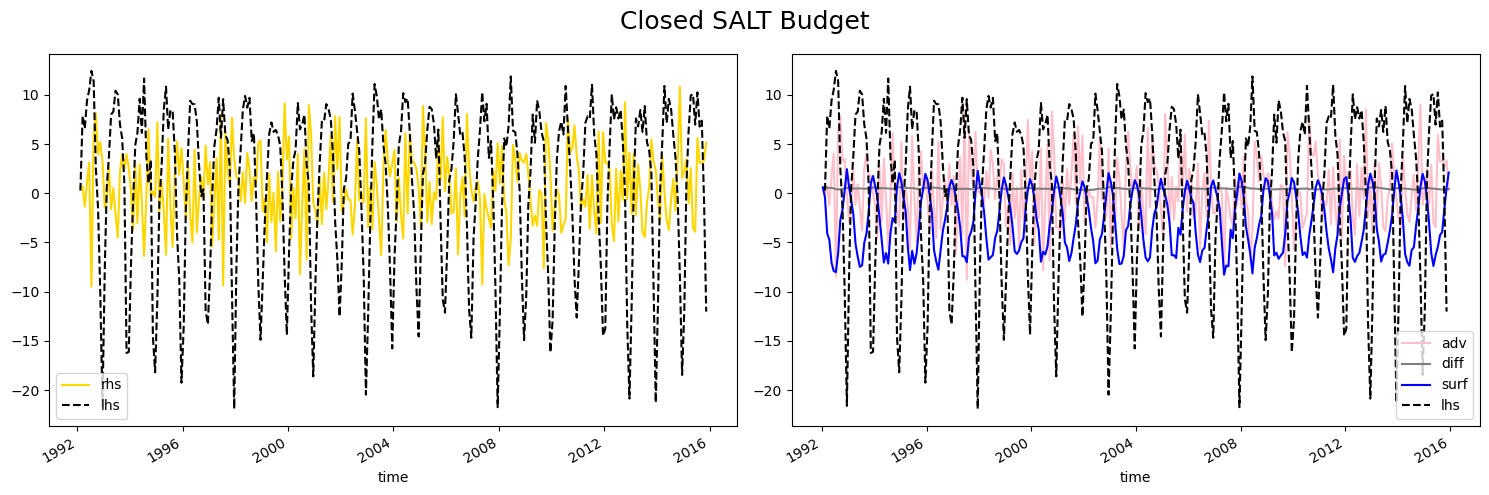

In [81]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))

(rhs/1e6).plot(color='gold', label='rhs', ax=ax0)
(lhs/1e6).plot(color='k', linestyle='--', label='lhs', ax=ax0)
ax0.legend()

(residual_adv/1e6).plot(color='pink', label='adv', ax=ax1)
(residual_diff/1e6).plot(color='grey', label='diff', ax=ax1)
(residual_surf/1e6).plot(color='blue', label='surf', ax=ax1)
(lhs/1e6).plot(color='k', linestyle='--', label='lhs', ax=ax1)
ax1.legend()

plt.suptitle('Closed SALT Budget', fontsize=18)
plt.tight_layout();